In [ ]:
#hide
import fastbook
fastbook.setup_book()

# Workshop 2

Plan:

1. Najważniejsze biblioteki/ekosystemy
2. Przykłady klasyfikacji,
3. Przykłady regresji,
4. Large language models
5. Metryki.

## Najważniejsze biblioteki/ekosystemy

Frameworki/ekosystemy:

- [scikit-learn](https://scikit-learn.org/)
- [fastai](https://docs.fast.ai/)
- [huggingface](https://huggingface.co/)
- xgboost


### chatgpt

- Najlepszym sposobem poznania jak wykorzystać LLM to korzystać z najlepszych dostępnych implementacji,
- obecnie (2023-10-26) jest to chatgpt.

### scikit-learn

- Punkt startowy,
- Dużo przykładów, świetne miejsce do nauki.

### fastai

Wiodąca grupa wokół [fastai](https://www.fast.ai/) i [fastbook](https://github.com/fastai/fastbook):

- Podstawy pod LLM,
- transfer learning,
- applied Machine Learning,
- demokratyzacja ML.


### huggingface

- Open Source Machine Learning: od danych po algorytmy,
- [transfomers](https://huggingface.co/docs/transformers/index) - state of art z kilkoma liniami kodu.

### Podstawowe

- [pandas](https://pandas.pydata.org/)
- [numpy](https://numpy.org/)
- [seaborn](https://seaborn.pydata.org/)

### Warto znać

- [opencv](https://opencv.org/)
- [pyarrow](https://arrow.apache.org/docs/python/index.html)
- oczywiśćie SQL :) 

### Frameworks dla serwowania modelu

[fastapi](https://fastapi.tiangolo.com/):

- data-driven
- łatwo mapować dane wejściowe na wyjściowe

### Najlepsze praktyki

Jeśli student uzyska lekkość z pracą z githubem oraz notebookami, warto porozmawiać o praktykach inżynierii oprogramowania, np., [nbdev](https://github.com/fastai/nbdev):

- ML engineering;
- pre-commit git hooks;
- best practises: quarto, github actions, dokumentacja, itp.

### Machine Learning setup

Chmura:

- Darmo:
  
  - Kaggle (2GUs, niedużo RAMu
  - Colab

- Szeroka ofera ([porównanie](https://cloud-gpus.com)), np., [runpod.io](https://www.runpod.io)

Uczelnia:

- ML lab na Merito

Własny setup (2023-10-16):

- 2x GTX 3090 or GTX 4090 ([Jeremy Howard, co-fonder of fast.ai](https://youtu.be/jkrNMKz9pWU?t=3217))
- Mac z dużą ilością ramu M2 Ultra
- Warto przeczytać guide na timdettmers.com [1](https://timdettmers.com/2023/01/30/which-gpu-for-deep-learning/comment-page-1/) i [2](https://timdettmers.com/2023/01/30/which-gpu-for-deep-learning/comment-page-2/).




## Przykład Klasyfikacja

```{mermaid}

flowchart LR
  Dane_1(x11,x12, x13, x14) --> Etykieta_1("Label 1 (y)")
  Dane_2(x21,x22, x23, x14) --> Etykieta_1
  
  Dane_3(x31,x32, x33, x34) --> Etykieta_2("Label 2 (y)")
```

Wykorzystamy przykład z [fastbook](https://github.com/fastai/fastbook/blob/master/02_production.ipynb):

In [ ]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [ ]:
import getpass

key = os.environ.get('AZURE_SEARCH_KEY', 'XXX')

In [ ]:
# results = search_images_bing(key, 'grizzly bear')
# ims = results.attrgot('contentUrl')
# len(ims)

In [ ]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

In [ ]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [ ]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [ ]:
#hide
dls = bears.dataloaders(path)

/usr/local/Caskroom/miniconda/base/envs/workshop_applied_ml_2/lib/python3.11/site-packages/fastai/data/transforms.py:225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(col):


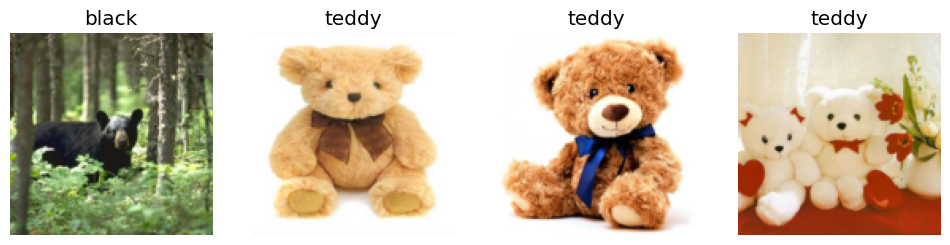

In [ ]:
dls.valid.show_batch(max_n=4, nrows=1)

### Przygotowanie danych

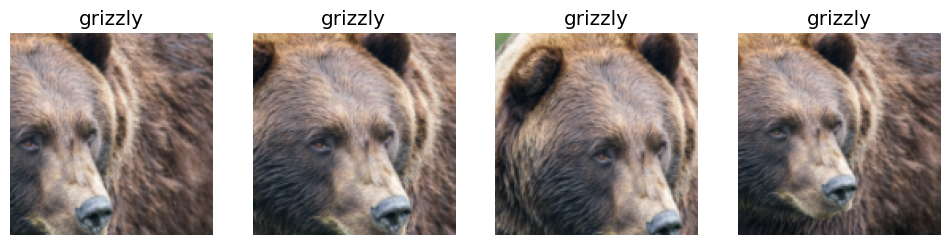

In [ ]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

### Data Augmentation

/usr/local/Caskroom/miniconda/base/envs/workshop_applied_ml_2/lib/python3.11/site-packages/torch/_tensor.py:1295: UserWarning: The operator 'aten::_linalg_solve_ex.result' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1682343657571/work/aten/src/ATen/mps/MPSFallback.mm:11.)
  ret = func(*args, **kwargs)


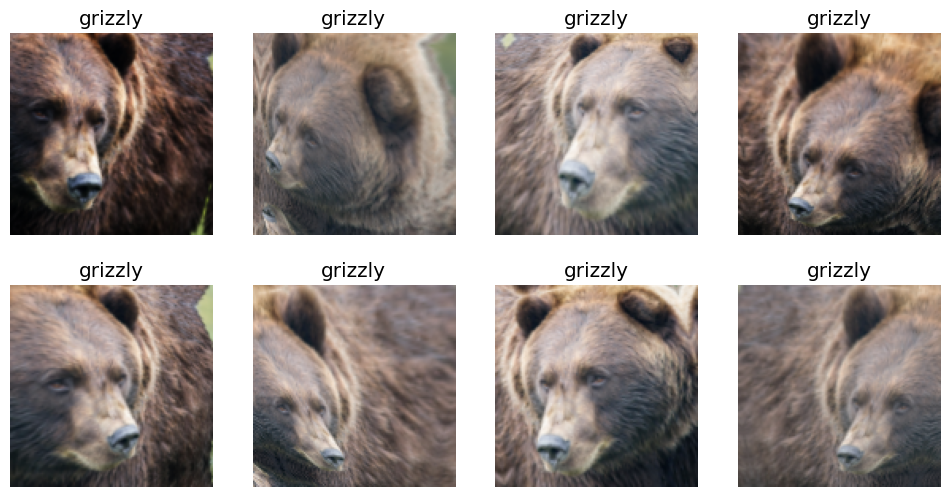

In [ ]:
#hide
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

### Trenowanie

Wykorzystamy istniejący model [rosnet18](https://fastai1.fast.ai/vision.models.html).

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/usr/local/Caskroom/miniconda/base/envs/workshop_applied_ml_2/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/workshop_applied_ml_2/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.612275,0.521937,1.000000,00:42


epoch,train_loss,valid_loss,error_rate,time
0,0.406744,0.231494,1.000000,00:33
1,0.347951,0.231516,1.000000,00:31
2,0.299730,0.247805,1.000000,00:33
3,0.243827,0.243242,1.000000,00:33


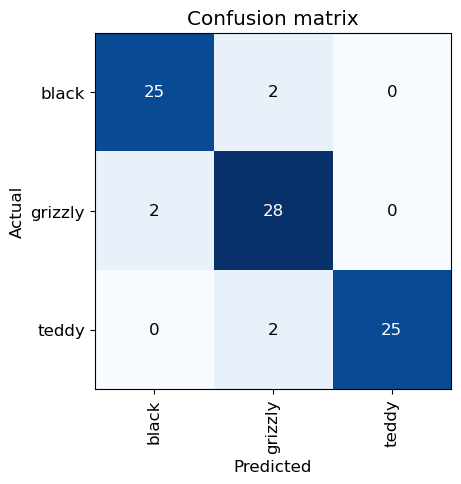

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

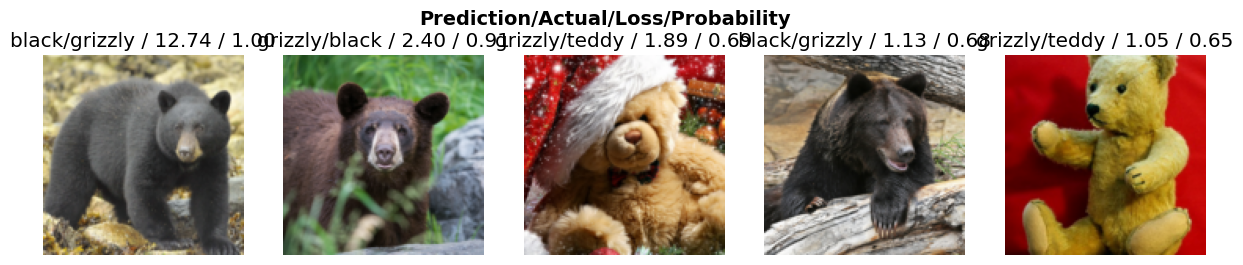

In [ ]:
interp.plot_top_losses(5, nrows=1)

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

## Przykłady dla Regresji

Więcej na [scikit-learn](https://scikit-learn.org/stable/modules/linear_model.html#robustness-regression-outliers-and-modeling-errors).

In [ ]:
from sklearn import linear_model

In [ ]:
reg = linear_model.LinearRegression()
reg.fit([[0, 0], [1, 1], [2, 2]], [0, 1, 2])

LinearRegression()

Coefficients: 
 [938.23786125]
Mean squared error: 2548.07
Coefficient of determination: 0.47


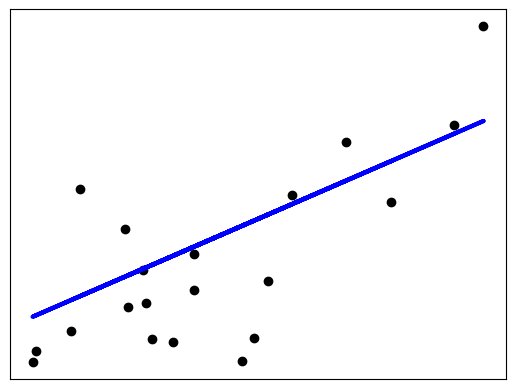

In [ ]:
# Code source: Jaques Grobler
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Load the diabetes dataset
diabetes_X, diabetes_y = datasets.load_diabetes(return_X_y=True)

# Use only one feature
diabetes_X = diabetes_X[:, np.newaxis, 2]

# Split the data into training/testing sets
diabetes_X_train = diabetes_X[:-20]
diabetes_X_test = diabetes_X[-20:]

# Split the targets into training/testing sets
diabetes_y_train = diabetes_y[:-20]
diabetes_y_test = diabetes_y[-20:]

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(diabetes_X_train, diabetes_y_train)

# Make predictions using the testing set
diabetes_y_pred = regr.predict(diabetes_X_test)

# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(diabetes_y_test, diabetes_y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(diabetes_y_test, diabetes_y_pred))

# Plot outputs
plt.scatter(diabetes_X_test, diabetes_y_test, color="black")
plt.plot(diabetes_X_test, diabetes_y_pred, color="blue", linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

## Co to jest language model?

ULMFit 3-step approach w oparciu o [LLM for hackers Jeremego Howarda](https://github.com/fastai/lm-hackers/blob/main/lm-hackers.ipynb) oraz :

```{mermaid}

flowchart LR
    PreTrain(LM\nPre-Training) --> FineTuning(LM\nFine Tuning) --> C(Classifier\nFine Tuning)
    Base(Base Model) -->  FineTuning
```

Gdzie:

- Base Model
- LM Fine Tuning - specjalizacja pod zadanie, domenę zadania
- Classifier Fine Tuning - zadanie


### Elementy:

- base model
- tokenizer
- fine-tunning
- task-based fine-tunning



#### Base model

"text-davinci-003"


#### Tokenizer

In [ ]:
#hide

!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.5/953.5 kB 7.7 MB/s eta 0:00:000m eta 0:00:01:01:01


In [ ]:
from tiktoken import encoding_for_model

In [ ]:
enc = encoding_for_model("text-davinci-003")
toks = enc.encode("They are running in the morning")

In [ ]:
[enc.decode_single_token_bytes(o).decode('utf-8') for o in toks]

['They', ' are', ' running', ' in', ' the', ' morning']

#### LM Fine Tuning

Będzie omówione w ćwiczeniu o klasyfikacji oparciu o tekst.

```python
learn = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=0.3, metrics=[accuracy, Perplexity()]
).to_fp16()
```

#### Classifier

Mając fine-tuned, model możemy przejść do klasfikatora:

```python
learn = text_classifier_learner(...)
```

## Metryki

W jaki sposób wyznaczamy jakość naszego modelu (model evaluation), dobre podsumowanie jak zawsze znajdziemy na [scikit-learn](https://scikit-learn.org/stable/modules/model_evaluation.html).

### Regresje

1. Mean Squared Error
2. Mean Log Squared Error

Przykład na podstawie dokumentacji [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html#sklearn.metrics.mean_squared_error) - Mean squared error regression loss:

In [ ]:
from sklearn.metrics import mean_squared_error
y_test = [3, -0.5, 2, 7]
y_pred = [2.5, 0.0, 2, 8]

mean_squared_error(y_test, y_pred)

0.375

In [ ]:
from sklearn.metrics import mean_squared_log_error

y_true = [3, 5, 2.5, 7]
y_pred = [2.5, 5, 4, 8]

mean_squared_log_error(y_true, y_pred)

0.03973012298459379

### Klasyfikacja

- accouracy score
- f1_score

  `F1 = 2 * (precision * recall) / (precision + recall)`

- confusion metrics

## Dziękuję za uwagę

![](img/intro.jpeg){width:100px;}

## *Pytania?*

# Materiały Dodatkowe

### Continuous integration / Continuous Deployment

Przykład:

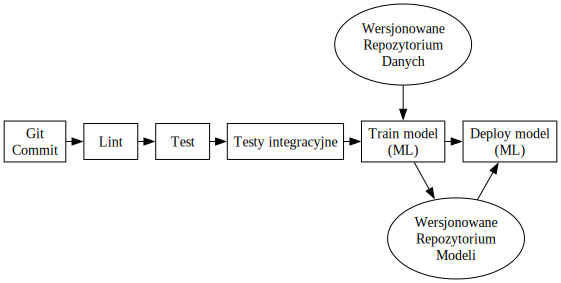

In [ ]:
from graphviz import Digraph, Source

cd = Source(
    """digraph {
    A [shape=box, label="Git\nCommit"]
    B [shape=box, label="Lint"]
    C [shape=box, label="Test"]
    D [shape=box, label="Testy integracyjne"]
    E [shape=box, label="Train model\n(ML)"]
    F [shape=box, label="Deploy model\n(ML)"]
    
    RD [label="Wersjonowane\nRepozytorium\nDanych"]
    {RD -> E}
    
    {rank=same; A -> B};
    {rank=same; B -> C};
    {rank=same; C -> D};
    {rank=same; D -> E}; 
    {rank=same; E -> F};
  
    G [label="Wersjonowane\nRepozytorium\nModeli"]
    
    {E -> G } [label="publikacja"];
    {G -> F};
    
}"""
)

cd

### Metryki w produkcji

4 Złote sygnały / Rate-Error-Duractin (RED):

- Latency
- Rate
- Errors
- Saturation (pamięć i CPU)